In [1]:
#Assignment 3
#Jingyang Wang
#Student number: 995429
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [2]:
df_wc= pd.read_csv("shots_World_Cup.csv")

In [3]:
df_eu= pd.read_csv("shots_European_Championship.csv")

In [4]:
df_eu.head(5)

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,31,91,29,0,1,0,0,0,0
1,1,143,71,29,0,1,0,0,1,0
2,1,220,96,57,0,1,0,0,1,0
3,1,248,96,61,0,0,0,1,1,0
4,1,557,75,33,0,0,1,0,0,0


In [5]:
df_eng= pd.read_csv("shots_England.csv")

In [6]:
df_fr= pd.read_csv("shots_France.csv")

In [7]:
df_ge= pd.read_csv("shots_Germany.csv")

In [8]:
df_it= pd.read_csv("shots_Italy.csv")

In [9]:
df_sp= pd.read_csv("shots_Spain.csv")

In [10]:
data = pd.concat([df_wc, df_sp, df_it, df_ge, df_fr, df_eng, df_eu], axis=0)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45287 entries, 0 to 1282
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   period       45287 non-null  int64
 1   time         45287 non-null  int64
 2   x            45287 non-null  int64
 3   y            45287 non-null  int64
 4   freeKick     45287 non-null  int64
 5   rightFoot    45287 non-null  int64
 6   leftFoot     45287 non-null  int64
 7   head         45287 non-null  int64
 8   opportunity  45287 non-null  int64
 9   goal         45287 non-null  int64
dtypes: int64(10)
memory usage: 3.8 MB


In [12]:
data.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,327,87,27,0,1,0,0,0,0
1,1,407,90,69,0,1,0,0,0,0
2,1,526,86,30,0,0,1,0,0,0
3,1,693,93,60,0,0,0,1,1,1
4,1,1266,86,38,0,0,1,0,0,0


In [13]:
data['x']=100-data['x']
data['C']=abs(data['y']-50)

In [14]:
 #Distance in metres and shot angle in radians.
x=data['x']*105/100
y=data['C']*65/100
data['Distance']=np.sqrt(x**2 + y**2)

In [15]:
a=np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))

data['Angle']=a

In [16]:
data['Angle1']=np.pi+a

In [17]:
p = np.array(data['Angle'].values.tolist())
q = np.array(data['Angle1'].values.tolist())
data['Angle'] = np.where(p < 0, q, p).tolist()

In [18]:
data = data.drop(['Angle1'], axis=1)

In [19]:
data['side_of_field']= 1*(data['y'] <  50)

In [20]:
data['out_swinging'] = 1*(data['side_of_field'] == 0)*(data['rightFoot'] == 1) \
                           + 1*(data['side_of_field'] == 1)*(data['leftFoot'] == 1)
data['in_swinging'] = 1*(data['side_of_field'] == 0)*(data['leftFoot'] == 1) \
                            + 1*(data['side_of_field'] == 1)*(data['rightFoot'] == 1)

In [21]:
data.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal,C,Distance,Angle,side_of_field,out_swinging,in_swinging
0,1,327,13,27,0,1,0,0,0,0,23,20.244135,0.246902,1,0,1
1,1,407,10,69,0,1,0,0,0,0,19,16.210259,0.298970,0,1,0
2,1,526,14,30,0,0,1,0,0,0,20,19.623710,0.281792,1,1,0
3,1,693,7,60,0,0,0,1,1,1,10,9.811855,0.575798,0,0,0
4,1,1266,14,38,0,0,1,0,0,0,12,16.641214,0.387650,1,1,0


In [22]:
#Two dimensional histogram
H_Shot=np.histogram2d(data['x'], data['y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=data[data['goal']==1]
H_Goal=np.histogram2d(goals_only['x'], goals_only['y'],bins=50,range=[[0, 100],[0, 100]])

In [23]:
#cited from Github: 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

def createPitch(length,width, unity,linecolor): # in meters
    # Code by @JPJ_dejong

    """
    creates a plot in which the 'length' is the length of the pitch (goal to goal).
    And 'width' is the width of the pitch (sideline to sideline). 
    Fill in the unity in meters or in yards.
    """
    #Set unity
    if unity == "meters":
        # Set boundaries
        if length >= 120.5 or width >= 75.5:
            return(str("Field dimensions are too big for meters as unity, didn't you mean yards as unity?\
                       Otherwise the maximum length is 120 meters and the maximum width is 75 meters. Please try again"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Left 5-meters Box
            plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
            plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)
            
            #Right 5 -eters Box
            plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
            plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)
            
            #Prepare Circles
            centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
            rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
            #Axis titles

    #check unity again
    elif unity == "yards":
        #check boundaries again
        if length <= 95:
            return(str("Didn't you mean meters as unity?"))
        elif length >= 131 or width >= 101:
            return(str("Field dimensions are too big. Maximum length is 130, maximum width is 100"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([18 ,18],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([0,18],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([18,0],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-18),length],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([(length-18), (length-18)],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([(length-18),length],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Left 6-yard Box
            plt.plot([0,6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([6,6],[(width/2+7.32/2+6),(width/2-7.32/2-6)],color=linecolor)
            plt.plot([6,0],[(width/2-7.32/2-6),(width/2-7.32/2-6)],color=linecolor)
            
            #Right 6-yard Box
            plt.plot([length,length-6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([length-6,length-6],[(width/2+7.32/2+6),width/2-7.32/2-6],color=linecolor)
            plt.plot([length-6,length],[(width/2-7.32/2-6),width/2-7.32/2-6],color=linecolor)
            
            #Prepare Circles; 10 yards distance. penalty on 12 yards
            centreCircle = plt.Circle((length/2,width/2),10,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((12,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-12,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=20,width=20,angle=0,theta1=312,theta2=48,color=linecolor)
            rightArc = Arc((length-11,width/2),height=20,width=20,angle=0,theta1=130,theta2=230,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
                
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax


def createPitchOld():
    #Taken from FC Python        
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color=linecolor)
    plt.plot([0,130],[90,90], color=linecolor)
    plt.plot([130,130],[90,0], color=linecolor)
    plt.plot([130,0],[0,0], color=linecolor)
    plt.plot([65,65],[0,90], color=linecolor)
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color=linecolor)
    plt.plot([0,16.5],[65,65],color=linecolor)
    plt.plot([16.5,0],[25,25],color=linecolor)
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color=linecolor)
    plt.plot([113.5,113.5],[65,25],color=linecolor)
    plt.plot([113.5,130],[25,25],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color=linecolor)
    plt.plot([5.5,5.5],[54,36],color=linecolor)
    plt.plot([5.5,0.5],[36,36],color=linecolor)
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color=linecolor)
    plt.plot([124.5,124.5],[54,36],color=linecolor)
    plt.plot([124.5,130],[36,36],color=linecolor)
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((65,45),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,45),0.8,color=linecolor)
    rightPenSpot = plt.Circle((119,45),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color=linecolor)
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

def createGoalMouth():
    #Adopted from FC Python
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Goal
    plt.plot([41.5-5.34,41.5-5.34],[-2,0],color=linecolor)
    plt.plot([23.5+5.34,41.5-5.34],[-2,-2],color=linecolor)
    plt.plot([23.5+5.34,23.5+5.34],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

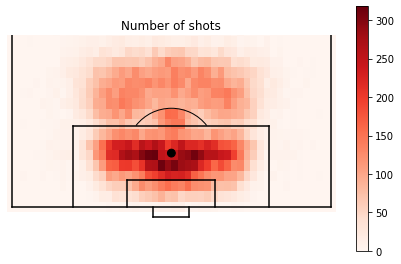

In [24]:
#Plot the number of shots from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show() 

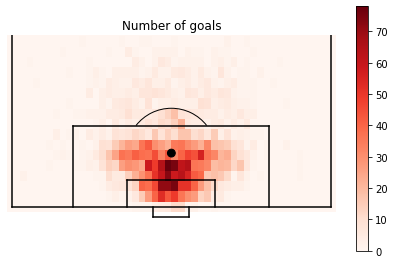

In [25]:
#Plot the number of GOALS from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

/var/folders/2k/b696_87d61s02g_hgdv98f4c0000gn/T/ipykernel_20143/1331244049.py:3: RuntimeWarning: invalid value encountered in true_divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


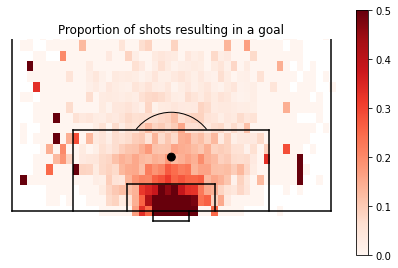

In [26]:
#Plot the probability of scoring from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [27]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Building an Expected Goals Model Using Random Forest

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import log_loss, roc_auc_score, roc_curve

## Naive Random Forest Model

In [30]:
model1=data.drop(['period','time'], axis=1)

In [31]:
model1.head()

,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal,C,Distance,Angle,side_of_field,out_swinging,in_swinging
0,13,27,0,1,0,0,0,0,23,20.244135,0.246902,1,0,1
1,10,69,0,1,0,0,0,0,19,16.210259,0.298970,0,1,0
2,14,30,0,0,1,0,0,0,20,19.623710,0.281792,1,1,0
3,7,60,0,0,0,1,1,1,10,9.811855,0.575798,0,0,0
4,14,38,0,0,1,0,0,0,12,16.641214,0.387650,1,1,0


In [32]:
y=model1['goal']
x=model1.drop(['goal'], axis=1)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [34]:
naive_rf_model=RandomForestClassifier(random_state=42)

In [35]:
naive_rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
train_y_hat=naive_rf_model.predict_proba(x_train)
naive_train_log_loss=log_loss(y_train, train_y_hat[:,1])
naive_train_roc_auc=roc_auc_score(y_train, train_y_hat[:,1])
print('The log loss of our model on the training set is : ' +str(round(naive_train_log_loss, 4)))
print('The ROC AUC of our model on the training set is : ' +str(round(naive_train_roc_auc, 3)))

The log loss of our model on the training set is : 0.2079
The ROC AUC of our model on the training set is : 0.902


In [37]:
test_y_hat=naive_rf_model.predict_proba(x_test)
naive_test_log_loss=log_loss(y_test, test_y_hat[:,1])
naive_test_roc_auc=roc_auc_score(y_test, test_y_hat[:,1])
print('The log loss of our model on the test set is : ' +str(round(naive_test_log_loss, 4)))
print('The ROC AUC of our model on the test set is : ' +str(round(naive_test_roc_auc, 3)))

The log loss of our model on the test set is : 0.7067
The ROC AUC of our model on the test set is : 0.753


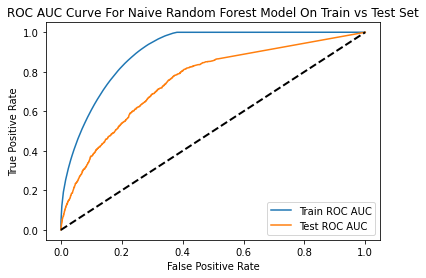

In [38]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat[:,1])

plt.plot(train_fpr, train_tpr, label='Train ROC AUC')
plt.plot(test_fpr, test_tpr, label='Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Random Forest Model On Train vs Test Set')
plt.show()

CPU times: user 31.7 s, sys: 284 ms, total: 32 s
Wall time: 32.3 s


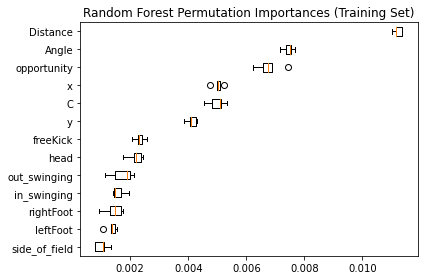

In [39]:
%time  result = permutation_importance(naive_rf_model, x_train, y_train)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances (Training Set)")
fig.tight_layout()
plt.show()

In [40]:
importances = naive_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([x.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

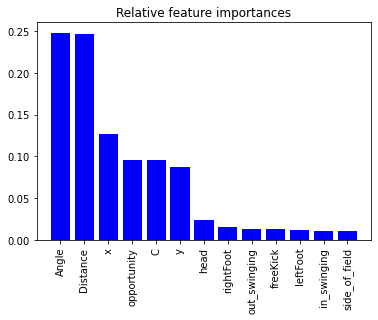

In [41]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(x.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, x.shape[1]])
plt.show()

We find that the features that we expected to be criticial are important, notably Distance and angle. 

## Building a Logistic Regression Model

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [43]:
initial_logistic_regression = sm.GLM(endog=y_train,exog=x_train,data=model1, 
                                           family=sm.families.Binomial()).fit()

/Users/jwang47/opt/anaconda3/envs/dsfb2env/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


In [44]:
train_y_hat = initial_logistic_regression.predict(x_train)
naive_train_log_loss = log_loss(y_train, train_y_hat)
naive_train_roc_auc = roc_auc_score(y_train, train_y_hat)
print('The log loss of our model on the training set is : ' +str(round(naive_train_log_loss, 4)))
print('The ROC AUC of our model on the training set is : ' +str(round(naive_train_roc_auc, 4)))

The log loss of our model on the training set is : 0.262
The ROC AUC of our model on the training set is : 0.8199


In [45]:
test_y_hat = initial_logistic_regression.predict(x_test)
naive_test_log_loss = log_loss(y_test, test_y_hat)
naive_test_roc_auc = roc_auc_score(y_test, test_y_hat)
print('The log loss of our model on the test set is : ' +str(round(naive_test_log_loss, 4)))
print('The ROC AUC of our model on the test set is : ' +str(round(naive_test_roc_auc, 3)))

The log loss of our model on the test set is : 0.2575
The ROC AUC of our model on the test set is : 0.813


In [46]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat)

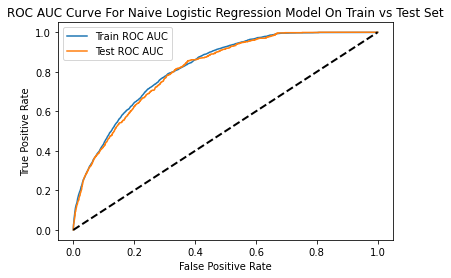

In [47]:
plt.plot(train_fpr, train_tpr, label = 'Train ROC AUC')
plt.plot(test_fpr, test_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [48]:
print(initial_logistic_regression.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                36229
Model:                            GLM   Df Residuals:                    36217
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9490.4
Date:                Mon, 21 Mar 2022   Deviance:                       18981.
Time:                        22:38:25   Pearson chi2:                 5.42e+04
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1307
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
x                 0.0548      0.025      2.214